### PLOT: Ungenutztes technisches Potential eines PV-Speichersystems

Hintergrund: Dissertation von Franziska Lobas-Funk

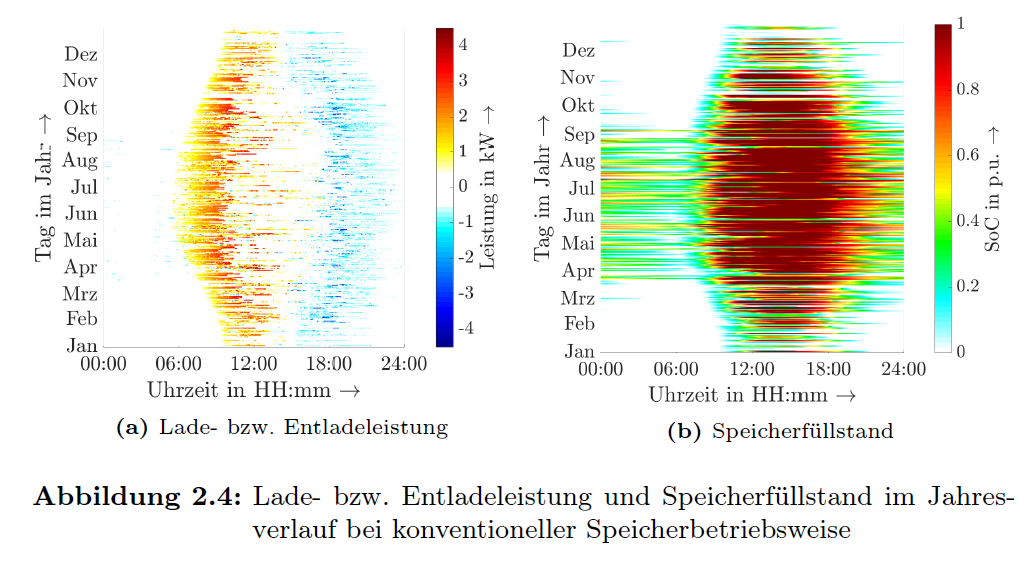

### Konfiguration

Vollbenutzungsstunden in D: "Die Übertragungsnetzbetreiber gehen in ihrem Trendszenario 2021 von 987 VBh für PV-Freiflächen-Anlagen in Deutschland aus, bei Dachanlagen von 922 VBh [ÜNB1]. Die Werte entsprechen Jahresnutzungsgraden („Kapazitätsfaktoren“) von 11,1 % bzw. 10,3 %, berechnet als Verhältnis der VBh zur Anzahl Jahresstunden. 

PV-Anlage: Lobas-Funk = 4600 kWh Jahresertrag ~ 5kWp PV-Anlage mit 922 VBh <br>
BSS = 5 kWh, Leistung 4,5 kW <br>
Last: htw-Profil Nr. 22 ~4000 kWh -> load 30.csv = 4085.4 kWh

In [13]:
# IMPORTS
import seaborn as sns
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
sns.set(font="Times New Roman", rc={'figure.figsize':(6.4,4.8)}, font_scale = 1.6)
# font scale automatically alters the font of everything in the graph, from the legend to both the axis labels and everything.


In [5]:
#Chose your hdf5 datafile
choice = "results_2023-02-02_#4.hdf5"
path = "C:\\VSVProjects\\smabui\\data\\database\\results\\" + choice
data = h5py.File(path, "r")

In [62]:
#Format hdf5 Data and convert to dataframe
Storage_P = np.array(data["Series"]["StorageSim-0.eStorage_0"]["P"])/1000
Storage_SOC = np.array(data["Series"]["StorageSim-0.eStorage_0"]["SOC"])
df = pd.DataFrame({'P': Storage_P, 'SoC': Storage_SOC})
df.to_csv("BS_Potential.csv")

### Check Load profile

In [ ]:
# read path
path = 'C:\\VSVProjects\\smabui\\data\\load\\4_persons_profile\\load_30.csv'
df = pd.read_csv(path, header=1)
name = path.split("\\")[-1]

# check annual consumption of load profile
Key_HTW = "P # [W]"
Key_HTW2 = "                P # [W]"
Key_Building = "load"
zeiteinheit = 15/60 # Building: 15/60 auch HTW hier
Jahresverbrauch= ((sum(df[Key_HTW2]))*zeiteinheit)/1000
print("Der Jahresverbrauch für das Profil -",name,"- beträgt:" ,round(Jahresverbrauch,2), "kWh")

### Tech. Potential - mosaik

In [3]:
# Read-in data
df = pd.read_csv("BS_Potential.csv")

In [4]:
# Create new column for day 
df['day'] = df.index.values/96
df['day'] = df['day'].apply(lambda x: int(x))

In [5]:
# add new column for time
df['time'] = df.index.values-df['day']*96
# use pivot function to resort datafarme
df_soc = df.pivot(index='day', columns='time', values='SoC').reset_index().drop(columns=['day']).sort_index(ascending=False)

In [6]:
# Sort_index to start with January on x-axis
df_p = df.pivot(index='day', columns='time', values='P').reset_index().drop(columns=['day']).sort_index(ascending=False)

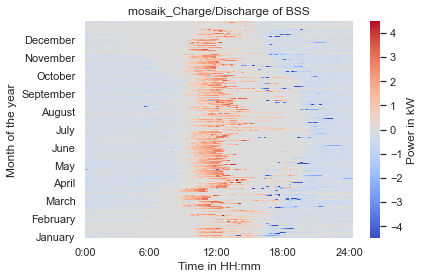

In [150]:
# PLOT: mosaik Charge/Discharge of BSS
plot_P = sns.heatmap(df_p, cmap=sns.color_palette("coolwarm", as_cmap=True),cbar_kws={"label":"Power in kW"})

plot_P.set(xlabel="Time in HH:mm",title = "mosaik_Charge/Discharge of BSS",ylabel = "Month of the year")
plot_P.set_xticks(np.array([0, 23, 47, 71, 95]))
plot_P.set_xticklabels(["0:00","6:00","12:00","18:00","24:00"])

# Index always starts with 0 in top left corner, therefore have to set yticks in reverse order
plot_P.set_yticks([*range(34,394,30)])
plot_P.set_yticklabels(reversed(["January","February","March","April","May","June","July","August","September","October","November","December"]))

plt.savefig("mosaik_Charge_Discharge_BSS.png", dpi=300)

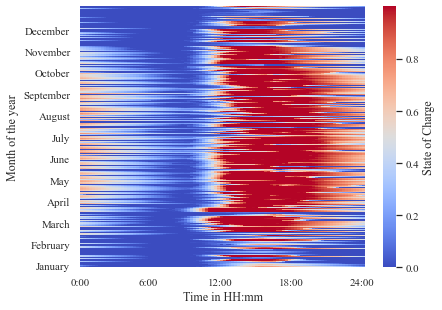

In [7]:
# PLOT: mosaik change of SoC

plot_SOC = sns.heatmap(df_soc, cmap=sns.color_palette("coolwarm", as_cmap=True),cbar_kws={"label":"State of Charge"})
plot_SOC.set(xlabel="Time in HH:mm",ylabel = "Month of the year")
#plot_SOC.set(title = "mosaik_SoC of BSS")

plot_SOC.set_xticks([0, 23, 47, 71, 95])
plot_SOC.set_xticklabels(["0:00","6:00","12:00","18:00","24:00"])


plot_SOC.set_yticks([*range(34,394,30)])
plot_SOC.set_yticklabels(reversed(["January","February","March","April","May","June","July","August","September","October","November","December"]))

plt.savefig("mosaik_SoC_BSS.png", dpi=300)

## Tech. Potential with eSE

In [2]:
# READ eSE data
eSE_Energiegehalt = pd.read_csv("eSE_Energieinhalt.csv",header=None,delimiter=";",decimal=",")
eSE_Energiegehalt.rename(columns={0:"Energiegehalt"},inplace=True)
# NOTE: Divide Energiegehalt by 7000 Wh for percentage values
eSE_Energiegehalt["Energiegehalt"] = eSE_Energiegehalt["Energiegehalt"]/7000
# Entladegrenze bei 10% eingestellt in eSE

In [3]:
# Create new column for day 
eSE_Energiegehalt['day'] = eSE_Energiegehalt.index.values/96
eSE_Energiegehalt['day'] = eSE_Energiegehalt['day'].apply(lambda x: int(x))

In [4]:
# Create new column for time of the day
eSE_Energiegehalt['time'] = eSE_Energiegehalt.index.values-eSE_Energiegehalt['day']*96

In [5]:
# create pivot table
eSE_Energiegehalt = eSE_Energiegehalt.pivot(index='day', columns='time', values='Energiegehalt').reset_index().drop(columns=['day']).sort_index(ascending=False)

In [22]:
# PLOT: eSE LOGARITHMIC SoC
plot_eSE_SOC = sns.heatmap(eSE_Energiegehalt, norm=LogNorm(), cmap=sns.color_palette("coolwarm", as_cmap=True),cbar_kws={"label":"State of Charge"})
#plot_eSE_SOC.set(title = "eSE_SoC of BSS")
plot_eSE_SOC.set(xlabel="Time in HH:mm",ylabel = "Month of the year")

plot_eSE_SOC.set_xticks([0, 23, 47, 71, 95])
plot_eSE_SOC.set_xticklabels(["0:00","6:00","12:00","18:00","24:00"])


plot_eSE_SOC.set_yticks([*range(34,394,30)])
plot_eSE_SOC.set_yticklabels(reversed(["January","February","March","April","May","June","July","August","September","October","November","December"]))

plt.savefig("eSE_LOGARITHMIC_SoC_BSS.png", dpi=300)

In [12]:
# PLOT: eSE change of SoC with standard scala
plot_eSE_SOC = sns.heatmap(eSE_Energiegehalt, cmap=sns.color_palette("coolwarm", as_cmap=True),cbar_kws={"label":"State of Charge","ticks":[x / 10 for x in range(0, 11)]}, rasterized=True)
#plot_eSE_SOC.set(title = "eSE_SoC of BSS")
plot_eSE_SOC.set(xlabel="Time in HH:mm \n \n (b) State of Charge",ylabel = "Month of the year")

plot_eSE_SOC.set_xticks([0, 23, 47, 71, 95])
plot_eSE_SOC.set_xticklabels(["0:00","6:00","12:00","18:00","24:00"])


plot_eSE_SOC.set_yticks([*range(34,394,30)])
plot_eSE_SOC.set_yticklabels(reversed(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]))

plt.tight_layout()
# plt.savefig("eSE_SoC_BSS.png", dpi=500)
plt.savefig("eSE_SoC_BSS.svg", format="svg")

In [14]:
# Read-in data for eSE Charge/Discharge plot
eSE_Leistung = pd.read_csv("eSE_Leistung.csv",header=None, delimiter=";",decimal=",")

eSE_Leistung.rename(columns={0:"P"},inplace=True)
# convert to kW
eSE_Leistung.P = eSE_Leistung.P/1000

In [15]:
eSE_Leistung["day"] = eSE_Leistung.index.values/96
eSE_Leistung["day"] = eSE_Leistung["day"].apply(lambda x : int(x))
eSE_Leistung["time"] = eSE_Leistung.index.values-eSE_Leistung["day"]*96

In [16]:
# Sort_index to start with January on x-axis
eSE_Leistung = eSE_Leistung.pivot(index='day', columns='time', values='P').reset_index().drop(columns=['day']).sort_index(ascending=False)

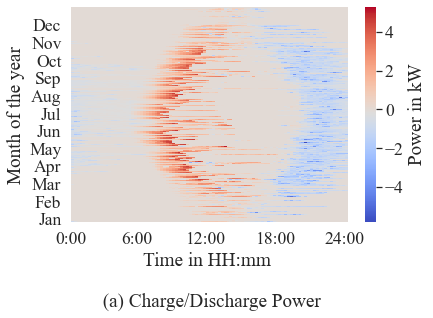

In [17]:
plot_eSE_P = sns.heatmap(eSE_Leistung, cmap=sns.color_palette("coolwarm", as_cmap=True),cbar_kws={"label":"Power in kW"}, rasterized=True)

plot_eSE_P.set(xlabel="Time in HH:mm \n\n (a) Charge/Discharge Power",ylabel = "Month of the year")
plot_eSE_P.set_xticks(np.array([0, 23, 47, 71, 95]))
plot_eSE_P.set_xticklabels(["0:00","6:00","12:00","18:00","24:00"])

# Index always starts with 0 in top left corner, therefore have to set yticks in reverse order
plot_eSE_P.set_yticks([*range(34,394,30)])
plot_eSE_P.set_yticklabels(reversed(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]))
#plot figure inside boundaries
plt.tight_layout()

plt.savefig("eSE_Charge_Discharge_BSS.svg", format="svg")

In [ ]:
## Von Merle: Behebt Bug, dass rechte Farbskala ggf. nicht bei 0 weiß ist
plot_P = sns.heatmap(
df_p,
cmap=custom_color_map,
center=0,
vmin=-p_max,
vmax=p_max,
cbar_kws={"label": "Power in kW"},
)

In [199]:
## CALCULATE Vollzyklen und Vollbenutzungsstunden
## Daten einlesen
eSE_Leistung_VZ = pd.read_csv("eSE_Leistung.csv",header=None, delimiter=";",decimal=",")
eSE_Leistung_VZ.rename(columns={0:"P"},inplace=True)

In [198]:
# Berechnun äquivaltente Vollzyklen (ÄVZ)
eSE_Leistung_VZ = abs(eSE_Leistung_VZ) * 0.25
ÄVZ = eSE_Leistung_VZ.sum()
ÄVZ = ÄVZ / (7000*2)
print(ÄVZ)

P    255.976328
dtype: float64


In [200]:
#BERECHNUNG Vollbenutzungsstunden T_vb bei P_Max von 5 kW
eSE_Leistung_VZ = abs(eSE_Leistung_VZ) * 0.25
T_vb = (eSE_Leistung_VZ.sum())/5000
print(T_vb)

In [210]:
# Jahresnutzungsgrad 
JNG = (T_vb/8760)*100
print(f"Der Jahresnutzungsgrad beträgt {JNG.values} % ")

Der Jahresnutzungsgrad beträgt [8.18189178] % 


## Test elenia colormap

In [9]:
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

# open 'elenia_cmap.pkl'
with open('elenia_cmap.pkl', 'rb') as handle:
    elenia_cmap = pickle.load(handle)

# get interpolated color map ('elenia_cmap_int') 
# with elenia primary colors ('prim_elenia_int')
elenia_cmap_int = elenia_cmap['elenia_cmap_int']['prim_elenia_int']

# register colormap 
mpl.colormaps.register(cmap=elenia_cmap_int)

# set registed colormap as default use
plt.set_cmap(elenia_cmap_int.name)


ValueError: A colormap named "prim_elenia_int" is already registered.

NameError: name 'elenia_cmap' is not defined

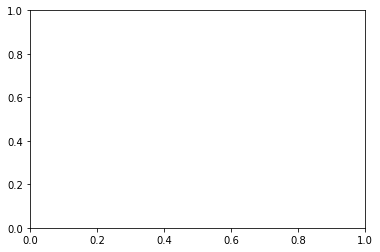

In [1]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['apple', 'blueberry', 'cherry', 'orange']
counts = [40, 100, 30, 55]
bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['red', 'blue', 'red', 'orange']

elenia_cmap_disc = elenia_cmap['elenia_cmap_disc']

ax.bar(fruits, counts, label=bar_labels, color=elenia_cmap_disc)

ax.set_ylabel('fruit supply')
ax.set_title('Fruit supply by kind and color')
ax.legend(title='Fruit color')

plt.show()

TypeError: 'LinearSegmentedColormap' object is not subscriptable

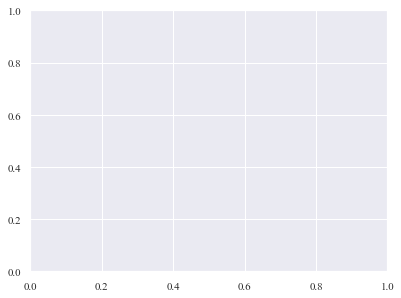

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# create some data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# set the 'prim_elenia_int' colormap
cmap = plt.get_cmap('prim_elenia_int')

# create a figure and axis object
fig, ax = plt.subplots()

# plot the data using the 'elenia_cmap_int' colormap
line1 = ax.plot(x, y1, linewidth=2, c=cmap["red"])
line2 = ax.plot(x, y2, linewidth=2, c=cmap(0.7))

# set the figure properties
#ax.set_facecolor('black')
ax.set_title("Liniendiagramm mit der 'prim_elenia_int' Farbkarte", fontsize=16)
ax.set_xlabel("X-Achse", fontsize=14)
ax.set_ylabel("Y-Achse", fontsize=14)
ax.grid(True)

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Farbskala", fontsize=12)

plt.show()
